In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm.notebook import tqdm_notebook
from joblib import Parallel, delayed
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from extract_latest_data import *
from util import *

### Function to compute sidewalk availability for a city

In [3]:
def compute_sidewalk_availability(city):
    
        osm_file = 'data/osm/latest/%s.osm.pbf'%(city)
        l = LatestHandler()
        l.apply_file(osm_file, locations = True)

        w_sidewalk = l.filter_data(highway_with_sidewalk)
        wo_sidewalk = l.filter_data(highway_without_sidewalk)
        wo_sidewalk_tag = l.filter_data(highway_without_sidewalk_tag)
        sidewalk = l.filter_data(sidewalk_qualifier)
        footway = l.filter_data(footway_qualifier)
        crossing = l.filter_data(highway_crossing_qualifier)

        highway_count = len(w_sidewalk) + len(wo_sidewalk) + len(wo_sidewalk_tag)
        sidewalk_tag_percentage = ((len(w_sidewalk) + len(wo_sidewalk)) / highway_count) * 100
        sidewalk_count = len(sidewalk)
        footway_count = len(footway)
        crossing_count = len(crossing)
        highway_to_sidewalk_ratio = sidewalk_count / highway_count

        return  [
                    city,
                    highway_count,
                    len(w_sidewalk),
                    len(wo_sidewalk),
                    len(wo_sidewalk_tag),
                    sidewalk_tag_percentage,
                    sidewalk_count,
                    footway_count,
                    crossing_count,
                    highway_to_sidewalk_ratio
                ]

### Compute for all cities in US and store in CSV
(Joblib for faster execution)

In [4]:
cities = pd.read_csv('data/picked_cities.csv')
cities = cities['abbr'].to_list()

stat_cities = Parallel(n_jobs=12)(
    delayed(compute_sidewalk_availability)(city) for city in cities
    ) # Almost 7x speed up than serial execution

colnames = ['city', 
            'highway_count', 
            'highway_with_sidewalk', 
            'highway_without_sidewalk',
            'highway_without_sidewalk_tag',
            'sidewalk_tag_percentage(%)', 
            'sidewalk_count', 
            'footway_count', 
            'crossing_count', 
            'highway_to_sidewalk_ratio']

df = pd.DataFrame(stat_cities, columns=colnames)
df = df.sort_values(by=['sidewalk_tag_percentage(%)'])

f = open('data/cities_name_loc.json')
data = json.load(f)
city_full_name = dict([(key, data[key][2].split(',')[0]) for key in data])
df['city']= df['city'].map(city_full_name)
df.to_csv('data/all_cities_sidewalk_stats.csv', index=False)

### Read CSV

In [3]:
stats = pd.read_csv('data/all_cities_sidewalk_stats.csv')
stats.head(10)

,city,highway_count,highway_with_sidewalk,highway_without_sidewalk,highway_without_sidewalk_tag,sidewalk_tag_percentage(%),sidewalk_count,footway_count,crossing_count,highway_to_sidewalk_ratio
0,Bridgeport,5646,3,0,5643,0.053135,155,1138,87,0.027453
1,Las Vegas,68217,38,5,68174,0.063034,956,4665,244,0.014014
2,Toledo,21924,12,2,21910,0.063857,3403,8415,1805,0.155218
3,Lafayette,7484,3,5,7476,0.106895,60,498,31,0.008017
4,Des Moines,20327,15,11,20301,0.127909,5463,11671,2775,0.268756
5,Fargo,12433,17,1,12415,0.144776,1443,4673,863,0.116062
6,Newark,15890,25,0,15865,0.157332,573,3201,590,0.036060
7,Concord,7363,3,11,7349,0.190140,875,2726,999,0.118837
8,Sioux Falls,13480,25,1,13454,0.192878,380,1595,146,0.028190
9,Birmingham,74413,31,134,74248,0.221735,1158,5047,268,0.015562


### Plot **percentage of highways with sidewalk tag** in all cities

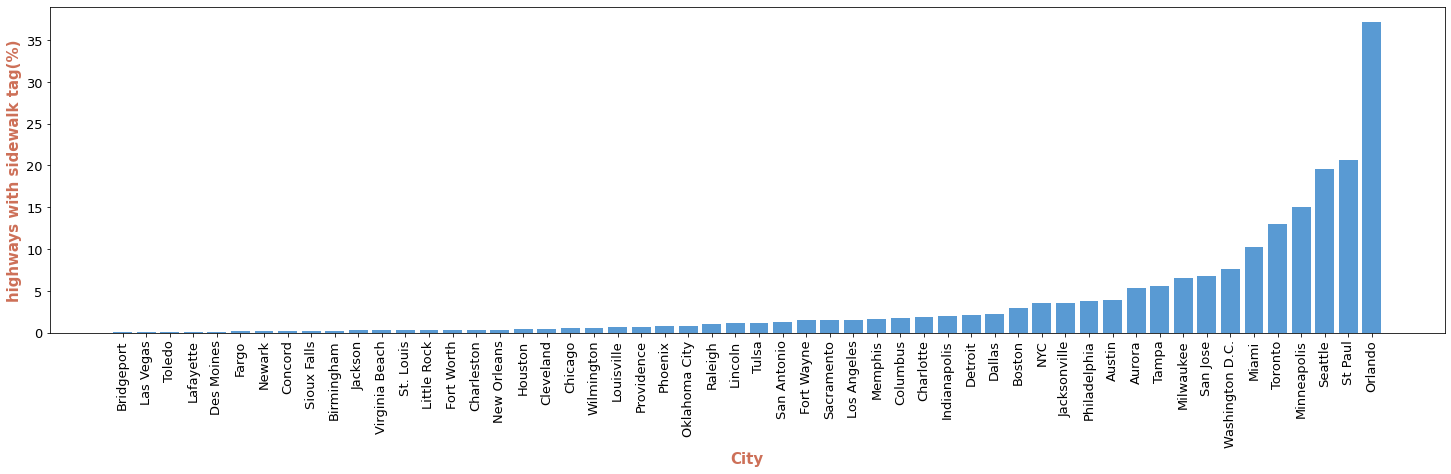

In [4]:
fig, ax = plt.subplots(figsize=(25, 6))

height = stats['sidewalk_tag_percentage(%)']
bars = stats['city']

x_pos = np.arange(len(bars))
ax.bar(x_pos, height, color='#599ad3')

# Rotation of the bar names
plt.xticks(x_pos, bars, rotation=90, fontsize='13')
plt.yticks(fontsize='13')
plt.ylabel('highways with sidewalk tag(%)', fontweight='bold', color = '#cd7058', fontsize='15')
plt.xlabel('City', fontweight='bold', color = '#cd7058', fontsize='15')

# Show graphic
plt.show()

### Plot **highway to sidewalk geometry ratio** for all cities

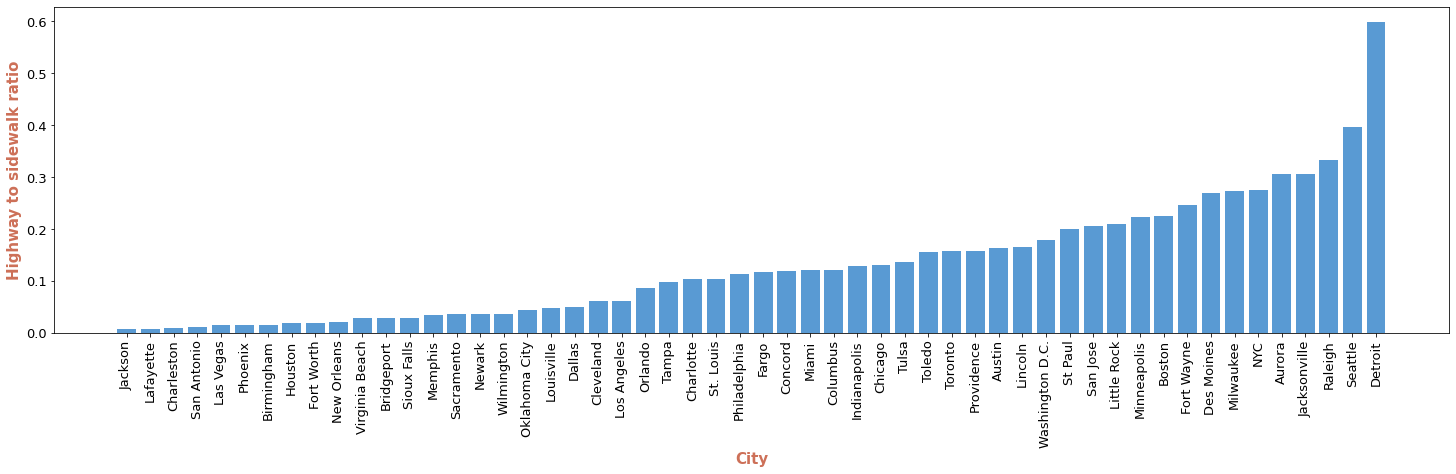

In [9]:
fig, ax = plt.subplots(figsize=(25, 6))

temp = stats.sort_values(by=['highway_to_sidewalk_ratio'])

height = temp['highway_to_sidewalk_ratio']
bars = temp['city']

x_pos = np.arange(len(bars))
ax.bar(x_pos, height, color='#599ad3')

# Rotation of the bar names
plt.xticks(x_pos, bars, rotation=90, fontsize='13')
plt.yticks(fontsize='13')
plt.ylabel('Highway to sidewalk ratio', fontweight='bold', color = '#cd7058', fontsize='15')
plt.xlabel('City', fontweight='bold', color = '#cd7058', fontsize='15')

# Show graphic
plt.show()